In [1]:
import numpy as np
import pandas as pd
from pandas import datetime
from pandas.plotting import autocorrelation_plot
from matplotlib import pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
from sklearn.model_selection import train_test_split as tts
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
#import matplotlib.pylab as plt #for visualization
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.ensemble import IsolationForest
import os
from matplotlib import dates as mpl_dates

In [2]:
def parser(x):
    return datetime.strptime(x,'%Y-%m-%d %H:%M')
dataset = pd.read_csv('C:/users/admin/swq/Dataset/Data7.csv',header=0, delimiter=',',index_col=0, parse_dates=[0], date_parser=parser)


 ## Dataset NaN values are filled with previous cell values

In [3]:
dataset = dataset.fillna(method ='pad') 
turb = dataset.filter(['Turb(FNU)'], axis=1)
#train_size,test_size = 1920, 3251#in paper given as 3169
train_size,test_size = 3000, 2171
#train_size,test_size = 1000, 1396
turb_train,turb_test = tts(turb,train_size = train_size, random_state=0, shuffle=False)

## Preparing Date index

In [4]:
dataset2 = pd.read_csv('C:/users/admin/swq/Dataset/Data7.csv',header=0, delimiter=',', parse_dates=[0], date_parser=parser)


dataset2.head()

date = dataset2.filter(['date_time'], axis=1)

date.head()

date_test = date.iloc[3000:,0]

print(date_test.shape)

(2171,)


## Performing ADF Test for checking stationarity of dataset

In [5]:
def check_adfuller(att):

    print('Results of Augmented Dickey Fuller Test: For Log Scale Differenced Turbidity(FNU)')
    print("--------For a stationary time series Test statistic is less than critical values-----------")
    dftest = adfuller(att, autolag='AIC')
    
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
        
    print(dfoutput)


In [6]:
check_adfuller(dataset['Turb(FNU)'])

Results of Augmented Dickey Fuller Test: For Log Scale Differenced Turbidity(FNU)
--------For a stationary time series Test statistic is less than critical values-----------
Test Statistic                   -5.039398
p-value                           0.000019
#Lags Used                       31.000000
Number of Observations Used    5139.000000
Critical Value (1%)              -3.431623
Critical Value (5%)              -2.862103
Critical Value (10%)             -2.567069
dtype: float64


The above results show that the dataset is stationary

## Plotting Rolling Mean and Standard Deviation of Dataset

In [54]:
def check_mean_std(ts, name):

    rolmean = ts.rolling(window=192).mean()
    rolstd = ts.rolling(window=192).std()
    plt.figure(figsize=(12,8))   
    print(name)
    
    plt.style.use('seaborn')
    plt.figure(figsize=(12,8))
    plt.plot(ts, color='red',label='Original')
    plt.plot(rolmean, color='black', label='Rolling Mean')
    plt.plot(rolstd, color='green', label = 'Rolling Std')
    plt.gcf().autofmt_xdate()
    date_format = mpl_dates.DateFormatter('%d, %b, %Y')
    plt.gca().xaxis.set_major_formatter(date_format)
    plt.tight_layout()
    plt.xlabel("Date")
    plt.ylabel("Turbidity")
    plt.title('Log Scale Differeced Turbidity(FNU) Rolling Mean & Standard Deviation')
    plt.legend()
    plt.show()



Turbidity


<Figure size 864x576 with 0 Axes>

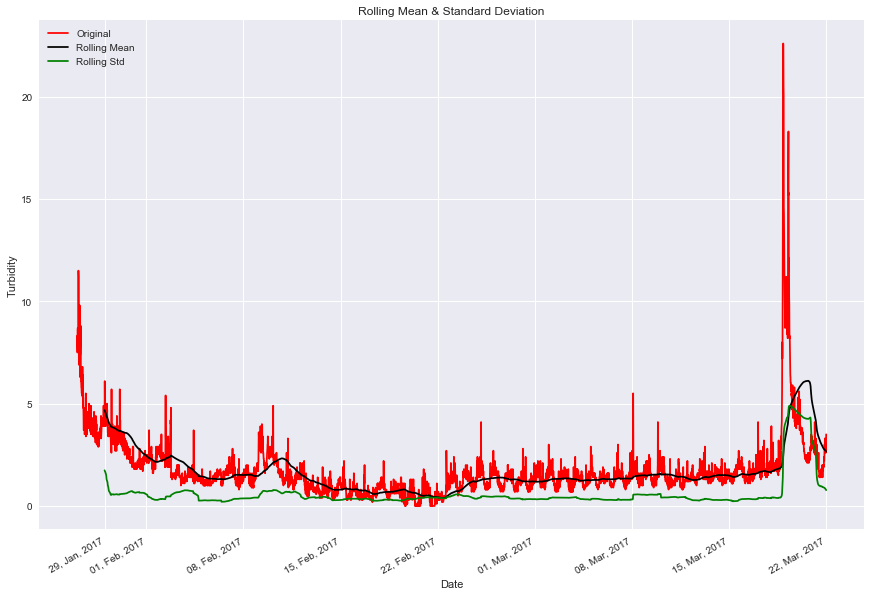

In [8]:
check_mean_std(dataset['Turb(FNU)'],'\n\nTurbidity')

## Plotting ACF and PACF plots to determine values of p and q for ARIMA Model

In [55]:
def acf_pacf_plots(dataset):
    ts_diff = dataset - dataset.shift()
    ts_diff.dropna(inplace=True)
    lag_acf = acf(ts_diff, nlags=20)
    lag_pacf = pacf(ts_diff, nlags=20, method='ols')
    
    # ACF
    plt.figure(figsize=(22,10))
    plt.style.use('seaborn')
    plt.subplot(121) 
    plt.plot(lag_acf)
    plt.axhline(y=0,linestyle='--',color='gray')
    plt.axhline(y=-1.96/np.sqrt(len(ts_diff)),linestyle='--',color='gray')
    plt.axhline(y=1.96/np.sqrt(len(ts_diff)),linestyle='--',color='gray')
    plt.xlabel("Lags")
    plt.ylabel("Autocorrelation")
    plt.title('Autocorrelation Function')
    
    # PACF
    plt.subplot(122)
    plt.style.use('seaborn')
    plt.plot(lag_pacf)
    plt.axhline(y=0,linestyle='--',color='gray')
    plt.axhline(y=-1.96/np.sqrt(len(ts_diff)),linestyle='--',color='gray')
    plt.axhline(y=1.96/np.sqrt(len(ts_diff)),linestyle='--',color='gray')
    plt.title('Partial Autocorrelation Function')
    plt.xlabel("Lags")
    plt.ylabel("Partial Autocorrelation")
    plt.tight_layout()

C:\Users\admin\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


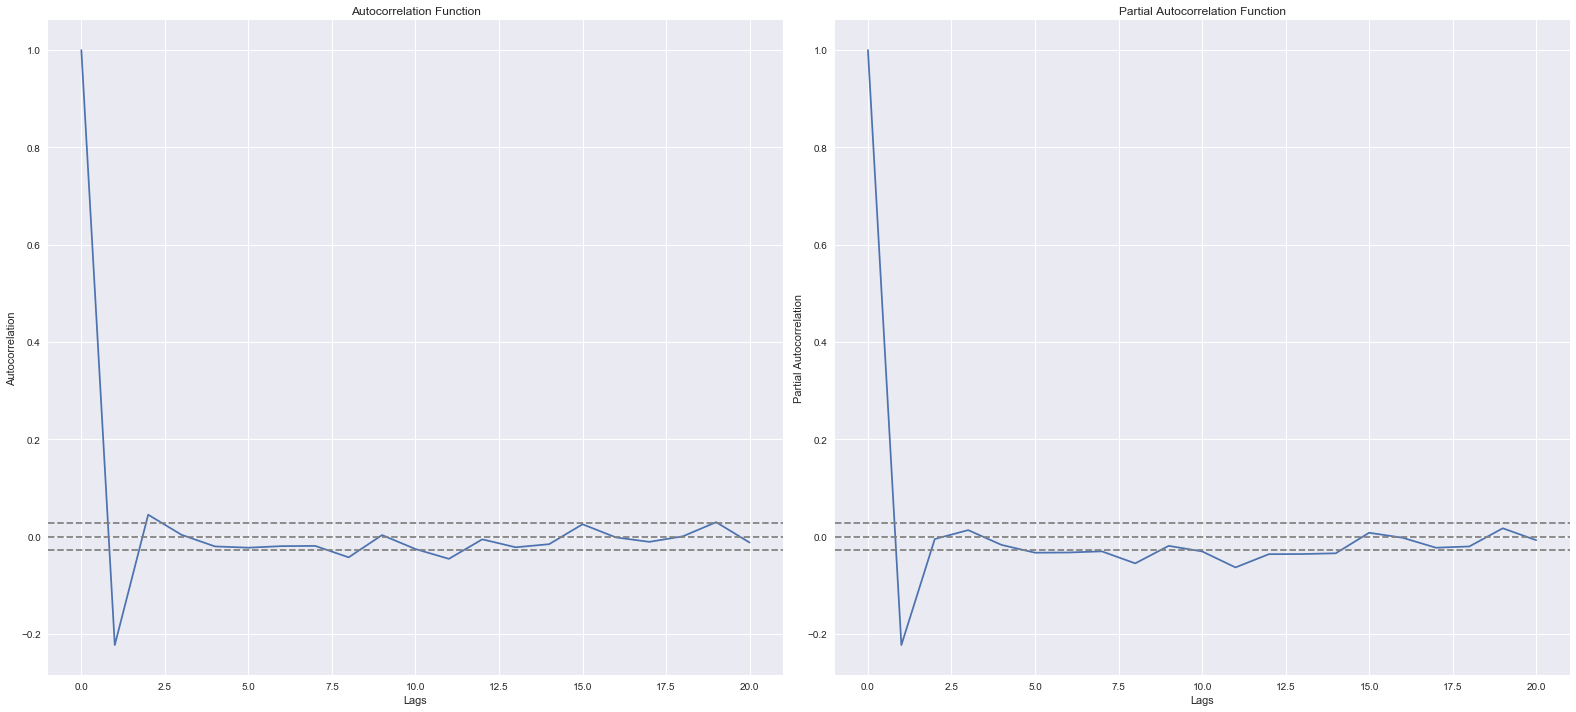

In [42]:
acf_pacf_plots(turb)

The first dip below the dotted line is considered as p by looking at the autocorrelation function while the first dip in Partial Autocorrelation Function is considered as q parameter. So by this plot we find p = 1 and q = 1

## Calculating a moving average of dataset to make dataset more stationary

In [47]:
# Moving average method for Turbidity
def moving_average():
    #turb_logScale = np.log(turb)
    #plt.plot(turb_logScale)

    turb_ma = turb.rolling(window=192).mean() #window size 192 denotes 1 day, giving rolling mean at daily level
    #sc_movingSTD = sc_logScale.rolling(window=192).std()

#   plt.plot(sc_logScale)
#plt.plot(sc_moving_Average, color='blue')
    '''
    plt.figure(figsize=(12,8))
    plt.style.use('seaborn')
    plt.plot(turb, color = "red",label = "Original")
    plt.plot(turb_ma, color='black', label = "turb moving_avg_mean")
    plt.title("Turbidity Rolling mean(mg/L) of Potomac River")
    plt.gcf().autofmt_xdate()
    date_format = mpl_dates.DateFormatter('%d, %b, %Y')
    plt.gca().xaxis.set_major_formatter(date_format)
    plt.tight_layout()
    plt.xlabel("Date")
    plt.ylabel("Turb(FNU)")
    plt.legend()
    plt.show()
    '''
    turb_ma_diff = turb - turb_ma
    #sc_LogScaleMinusMovingAverage.head(100)
    
    turb_ma_diff.dropna(inplace=True)
    #print(sc_rolmean,sc_rolstd)

    check_adfuller(turb_ma_diff['Turb(FNU)'])
    check_mean_std(turb_ma_diff['Turb(FNU)'], '\n\nTurbidity(FNU)')

Results of Augmented Dickey Fuller Test: For Log Scale Differenced Turbidity(FNU)
--------For a stationary time series Test statistic is less than critical values-----------
Test Statistic                   -5.544052
p-value                           0.000002
#Lags Used                       31.000000
Number of Observations Used    4948.000000
Critical Value (1%)              -3.431672
Critical Value (5%)              -2.862124
Critical Value (10%)             -2.567081
dtype: float64


Turbidity(FNU)


<Figure size 864x576 with 0 Axes>

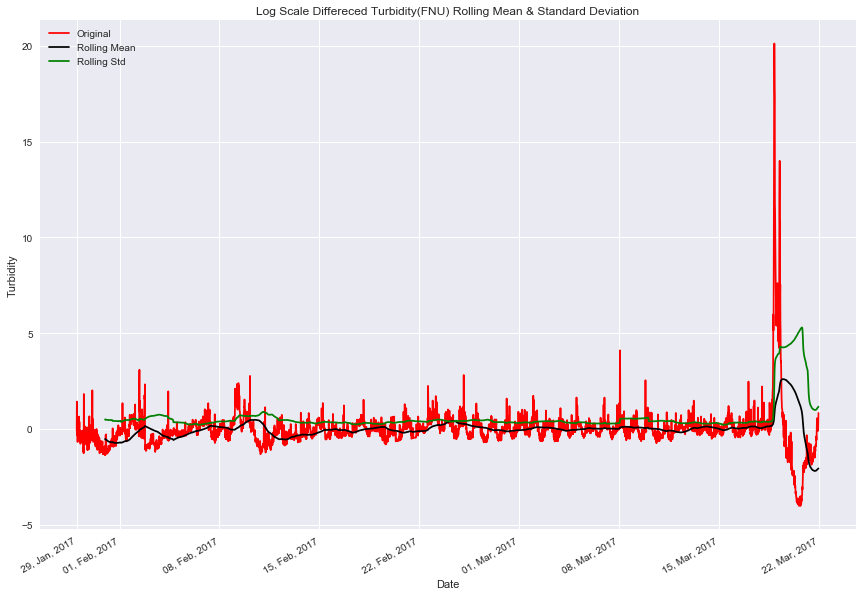

In [48]:
moving_average()

## Arima Model:

### There are mainly 2 methods of making forecasts:-
1. predict() : Used to make out of step, one step predictions
2. forecast() : Used to make 1 step ahead predictions

### Using Auto arima to find out the best seasonal parameters for dataset

In [11]:
# Import the library 
from pmdarima import auto_arima 
  
# Ignore harmless warnings 
import warnings 
warnings.filterwarnings("ignore") 
  
# Fit auto_arima function to AirPassengers dataset 
stepwise_fit = auto_arima(turb, start_p = 1, start_q = 1, 
                          max_p = 3, max_q = 3, m = 12, 
                          start_P = 0, seasonal = True, 
                          d = None, D = 1, trace = True, 
                          error_action ='ignore',   # we don't want to know if an order does not work 
                          suppress_warnings = True,  # we don't want convergence warnings 
                          stepwise = True)           # set to stepwise 
  
# To print the summary 
stepwise_fit.summary() 

Performing stepwise search to minimize aic
Fit ARIMA(1,0,1)x(0,1,1,12) [intercept=True]; AIC=4889.870, BIC=4922.612, Time=24.122 seconds
Fit ARIMA(0,0,0)x(0,1,0,12) [intercept=True]; AIC=14747.779, BIC=14760.876, Time=0.234 seconds
Fit ARIMA(1,0,0)x(1,1,0,12) [intercept=True]; AIC=6821.953, BIC=6848.147, Time=5.164 seconds
Fit ARIMA(0,0,1)x(0,1,1,12) [intercept=True]; AIC=10514.891, BIC=10541.085, Time=6.981 seconds
Fit ARIMA(0,0,0)x(0,1,0,12) [intercept=False]; AIC=14746.632, BIC=14753.180, Time=0.156 seconds
Fit ARIMA(1,0,1)x(0,1,0,12) [intercept=True]; AIC=8220.695, BIC=8246.889, Time=2.070 seconds
Fit ARIMA(1,0,1)x(1,1,1,12) [intercept=True]; AIC=4890.690, BIC=4929.981, Time=28.032 seconds
Near non-invertible roots for order (1, 0, 1)(1, 1, 1, 12); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA(1,0,1)x(0,1,2,12) [intercept=True]; AIC=4888.995, BIC=4928.286, Time=75.850 seconds
Near non-invertible roots for order (1, 0, 1

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                 5171
Model:             SARIMAX(2, 0, 2)x(0, 1, [1], 12)   Log Likelihood               -2424.642
Date:                              Fri, 01 May 2020   AIC                           4863.284
Time:                                      21:03:58   BIC                           4909.124
Sample:                                           0   HQIC                          4879.325
                                             - 5171                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -2.573e-05    8.5e-05     -0.303      0.762      -0.000       0.000
ar.L1          0.8557      0.107      8.030      0.000       0.647       1.065
ar.L2          0.1132      0.104      1.088      0.277      -0.091       0.317
ma.L1         -0.0921      0.106     -0.867      0.386      -0.300       0.116
ma.L2          0.0411      0.020      2.008      0.045       0.001       0.081
ma.S.L12      -0.9905      0.002   -403.436      0.000      -0.995      -0.986
sigma2         0.1483      0.001    163.824      0.000       0.147       0.150
===================================================================================
Ljung-Box (Q):                      230.94   Jarque-Bera (JB):            243127.50
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.40   Skew:                             1.55
Prob(H) (two-sided):                  0.00   Kurtosis:                        36.49
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Training with whole dataset

In [10]:
# Fit a SARIMAX(0, 1, 1)x(2, 1, 1, 12) on the training set 
from statsmodels.tsa.statespace.sarimax import SARIMAX 
  
model = SARIMAX(turb,  
                order = (2, 0, 2),  
                seasonal_order =(0, 1, 1, 12)) 
  
result = model.fit() 
result.summary() 

C:\Users\admin\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\admin\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                            Turb(FNU)   No. Observations:                 5171
Model:             SARIMAX(2, 0, 2)x(0, 1, [1], 12)   Log Likelihood               -2419.413
Date:                              Sun, 03 May 2020   AIC                           4850.826
Time:                                      19:57:56   BIC                           4890.117
Sample:                                           0   HQIC                          4864.575
                                             - 5171                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0653      0.106     10.022      0.000       0.857       1.274
ar.L2         -0.0901      0.104     -0.867      0.386      -0.294       0.114
ma.L1         -0.3018      0.105     -2.861      0.004      -0.508      -0.095
ma.L2          0.0843      0.020      4.313      0.000       0.046       0.123
ma.S.L12      -0.9813      0.003   -299.303      0.000      -0.988      -0.975
sigma2         0.1484      0.001    166.941      0.000       0.147       0.150
===================================================================================
Ljung-Box (Q):                      218.49   Jarque-Bera (JB):            238945.16
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.40   Skew:                             1.47
Prob(H) (two-sided):                  0.00   Kurtosis:                        36.21
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Training SARIMA MODEL with whole turb_train dataset

In [56]:
# Fit a SARIMAX(0, 1, 1)x(2, 1, 1, 12) on the training set 
from statsmodels.tsa.statespace.sarimax import SARIMAX 
  
model = SARIMAX(turb_train,  
                order = (2, 0, 2),  
                seasonal_order =(2, 1, 1, 12)) 
  
result = model.fit() 
result.summary() 

C:\Users\admin\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\admin\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\admin\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                            Turb(FNU)   No. Observations:                 3000
Model:             SARIMAX(2, 0, 2)x(2, 1, [1], 12)   Log Likelihood                -914.384
Date:                              Wed, 13 May 2020   AIC                           1844.769
Time:                                      19:10:55   BIC                           1892.788
Sample:                                           0   HQIC                          1862.044
                                             - 3000                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5496      0.112      4.906      0.000       0.330       0.769
ar.L2          0.4367      0.111      3.942      0.000       0.220       0.654
ma.L1         -0.0820      0.113     -0.726      0.468      -0.303       0.139
ma.L2         -0.3265      0.061     -5.334      0.000      -0.447      -0.207
ar.S.L12      -0.0167      0.015     -1.122      0.262      -0.046       0.012
ar.S.L24      -0.0005      0.015     -0.035      0.972      -0.030       0.029
ma.S.L12      -0.9827      0.005   -189.419      0.000      -0.993      -0.973
sigma2         0.1059      0.001     90.696      0.000       0.104       0.108
===================================================================================
Ljung-Box (Q):                      104.93   Jarque-Bera (JB):             23474.17
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.37   Skew:                             0.85
Prob(H) (two-sided):                  0.00   Kurtosis:                        16.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Predictions from start of turb_test to end 

In [57]:
#predictions with ARIMA
start = len(turb_train)
end = len(turb_train) +len(turb_test ) - 1
#start = end
#end = end + 2000
#start = parser('2017-02-16 00:15')
#end = parser('2017-03-21 23:45')
# Predictions for one-year against the test set 
predictions = result.predict(start, end, 
                             typ = 'linear').rename("Predictions") 
  


C:\Users\admin\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


### Plotting the predictions made for turb_test standalone

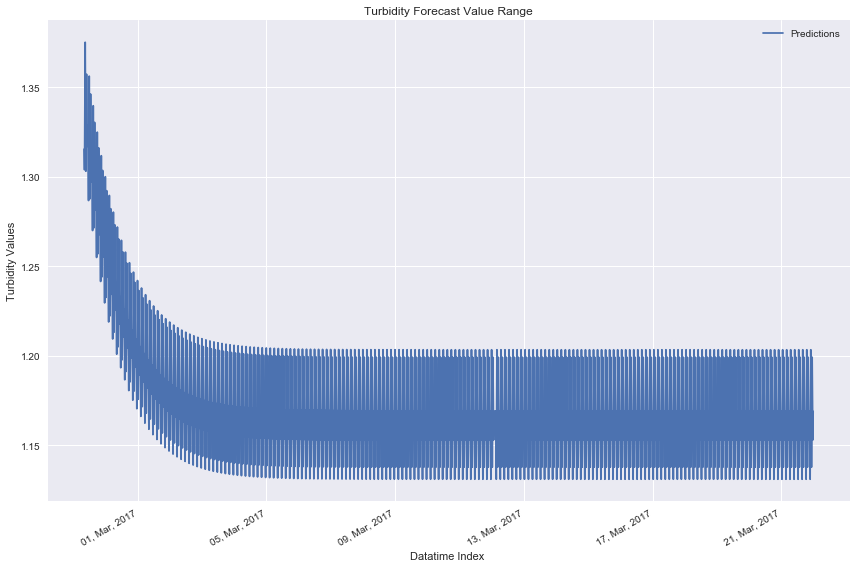

In [58]:
plt.style.use('seaborn')
plt.figure(figsize=(12,8))
plt.plot_date(date_test,predictions, linestyle='solid', marker='')
plt.gcf().autofmt_xdate()
date_format = mpl_dates.DateFormatter('%d, %b, %Y')
plt.gca().xaxis.set_major_formatter(date_format)
plt.xlabel("Datatime Index ")
plt.ylabel("Turbidity Values")
plt.title('Turbidity Forecast Value Range')
plt.legend()
plt.tight_layout()

The above graph shows us a range of possible values in our test dataset

### SARIMAX Comparison Plot : Original vs Predicted  

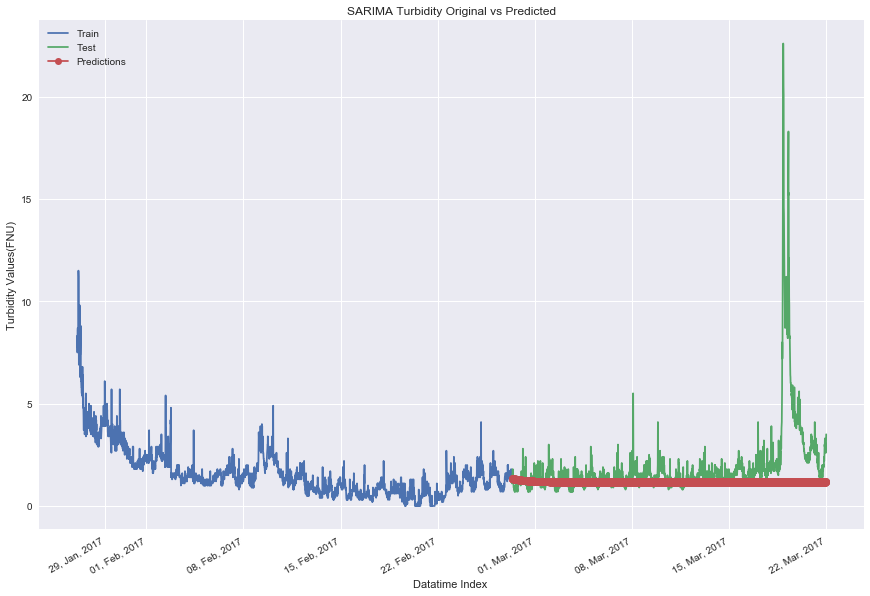

In [59]:
# plot predictions and actual values 

plt.style.use('seaborn')
plt.figure(figsize=(12,8))

plt.plot( turb_train, label='Train')
plt.plot(turb_test, label='Test')
plt.plot_date(date_test,predictions, linestyle='solid')
#plt.plot(predictions, label='Predictions')

plt.gcf().autofmt_xdate()
date_format = mpl_dates.DateFormatter('%d, %b, %Y')
plt.gca().xaxis.set_major_formatter(date_format)
plt.tight_layout()
plt.xlabel("Datatime Index ")
plt.ylabel("Turbidity Values(FNU)")
plt.title('SARIMA Turbidity Original vs Predicted')
plt.legend()
plt.legend(loc='best')
plt.show()
#predictions.plot(legend = True) 
#turb_test.plot(legend = True) 

## Error Analysis

#### Generating prerequisite arrays for error Calculation

In [102]:
predictions_values = predictions.values

print(predictions_values.size)

turb_test_values = turb_test.values

print(turb_test_values.size)

expected = turb_test_values
predicted = predictions_values

2171
2171


#### Bias Calculation

In [103]:
forecast_errors = [expected[i]-predicted[i] for i in range(len(expected))]
bias = sum(forecast_errors) * 1.0/len(expected)
print('Bias: %f' % bias)

Bias: 0.728940


#### Mean Absolute Error

In [104]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(expected, predicted)
print('Mean Absolute Error: %f' % mae)

Mean Absolute Error: 0.816485


#### Mean Squared Error

In [105]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(expected, predicted)
print('MSE: %f' % mse)

MSE: 4.080467


#### Root Mean Squared Error

In [106]:
from math import sqrt
rmse_sarima = sqrt(mse)
print('RMSE: %f' % rmse_sarima)

RMSE: 2.020017


## Arima with a Differenced Series 

In [7]:
from pandas import read_csv
from statsmodels.tsa.arima_model import ARIMA
import numpy

# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return numpy.array(diff)

# invert differenced value
def inverse_difference(history, yhat, interval):
    return yhat + history[-interval]

# load dataset
#series = read_csv('dataset.csv', header=None)
series = turb
# seasonal difference
X = series.values
day = 192#entries in a day
differenced = difference(X, day)
# fit model
model = ARIMA(differenced, order=(1,0,1))
model_fit = model.fit(disp=0)
# print summary of fit model
print(model_fit.summary())

#predictions with ARIMA
start = len(turb_train)
end = len(turb_train) +len(turb_test ) - 1

# predict
#forecast = model_fit.forecast()[0]
forecast2 = model_fit.predict(start, end)



                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 4979
Model:                     ARMA(1, 1)   Log Likelihood               -3922.216
Method:                       css-mle   S.D. of innovations              0.532
Date:                Wed, 13 May 2020   AIC                           7852.431
Time:                        18:10:22   BIC                           7878.483
Sample:                             0   HQIC                          7861.564
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1007      0.200     -0.502      0.615      -0.494       0.292
ar.L1.y        0.9700      0.004    270.838      0.000       0.963       0.977
ma.L1.y       -0.1961      0.014    -14.348      0.0

In [51]:
# invert the differenced forecast to something usable
forecast2_inverted = inverse_difference(X, forecast2, 50)

### Plotting the predictions independently

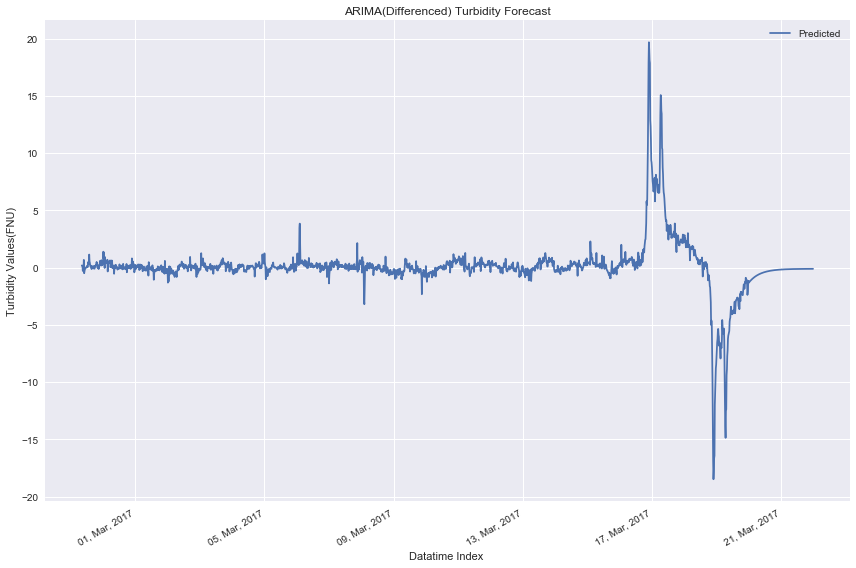

In [35]:
plt.style.use('seaborn')
plt.figure(figsize=(12,8))
plt.plot_date(date_test,forecast2, linestyle='solid', marker='',label='Predicted')
plt.gcf().autofmt_xdate()
date_format = mpl_dates.DateFormatter('%d, %b, %Y')
plt.gca().xaxis.set_major_formatter(date_format)
plt.xlabel("Datatime Index ")
plt.ylabel("Turbidity Values(FNU)")
plt.title('ARIMA(Differenced) Turbidity Forecast')
plt.legend(loc='best')
plt.tight_layout()

### Comparison Original vs Predicted

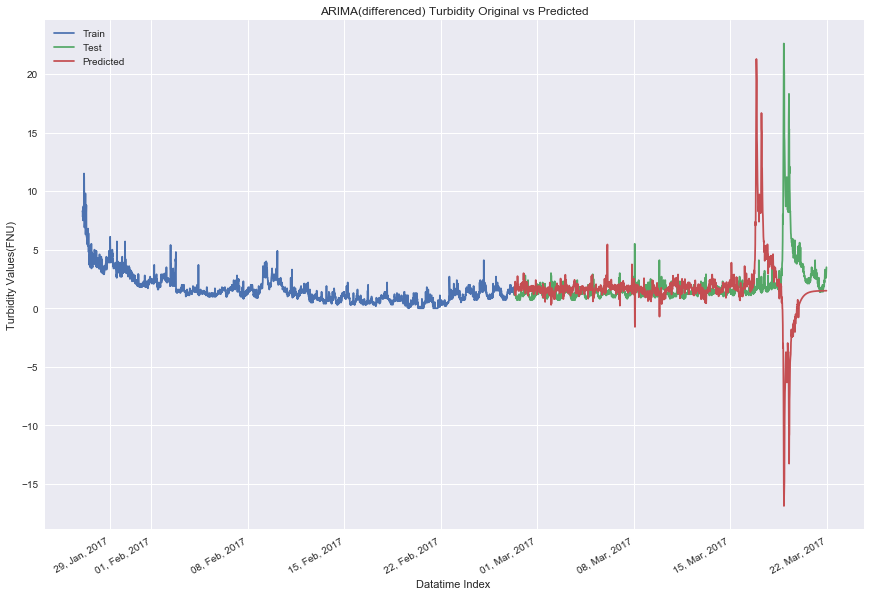

In [52]:
# plot predictions and actual values 

plt.style.use('seaborn')
plt.figure(figsize=(12,8))

plt.plot(turb_train, label='Train')
plt.plot(turb_test, label='Test')
plt.plot_date(date_test,forecast2_inverted, linestyle='solid',marker='',label='Predicted')
#plt.plot(predictions, label='Predictions')

plt.gcf().autofmt_xdate()
date_format = mpl_dates.DateFormatter('%d, %b, %Y')
plt.gca().xaxis.set_major_formatter(date_format)
plt.tight_layout()
plt.xlabel("Datatime Index ")
plt.ylabel("Turbidity Values(FNU)")
plt.title('ARIMA(differenced) Turbidity Original vs Predicted')
plt.legend(loc='best')
plt.show()
#predictions.plot(legend = True) 
#turb_test.plot(legend = True) 

### Error Calculation

In [53]:
# Load specific evaluation tools 
from sklearn.metrics import mean_squared_error 
from statsmodels.tools.eval_measures import rmse 
  
# Calculate root mean squared error 
print(rmse(turb_test, forecast2_inverted))
  
# Calculate mean squared error 
print(mean_squared_error(turb_test, forecast2_inverted))

[1.88370706 1.88366642 1.8899411  ... 1.92388199 1.92385779 1.92383432]
14.75663620303307


## ARIMA without differencing

In [87]:
# fit model:ARIMA
ts = turb_train
order=(1,0,1)
model = ARIMA(ts, order=order) # (ARMA) = (p,d,q)
model_fit = model.fit(disp=0)
#print summary of fit model
print(model_fit.summary())


C:\Users\admin\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                              ARMA Model Results                              
Dep. Variable:              Turb(FNU)   No. Observations:                 3000
Model:                     ARMA(1, 1)   Log Likelihood                -908.546
Method:                       css-mle   S.D. of innovations              0.327
Date:                Wed, 13 May 2020   AIC                           1825.093
Time:                        19:26:51   BIC                           1849.118
Sample:                             0   HQIC                          1833.734
                                                                              
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               2.3031      1.006      2.290      0.022       0.332       4.274
ar.L1.Turb(FNU)     0.9976      0.002    562.488      0.000       0.994       1.001
ma.L1.Turb(FNU)    -0.5856      

In [88]:
#predictions with ARIMA
start = len(turb_train)
end = len(turb_train) +len(turb_test ) - 1

In [89]:
# predict
#forecast = model_fit.forecast()[0]
forecast3 = model_fit.predict(start, end)

C:\Users\admin\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


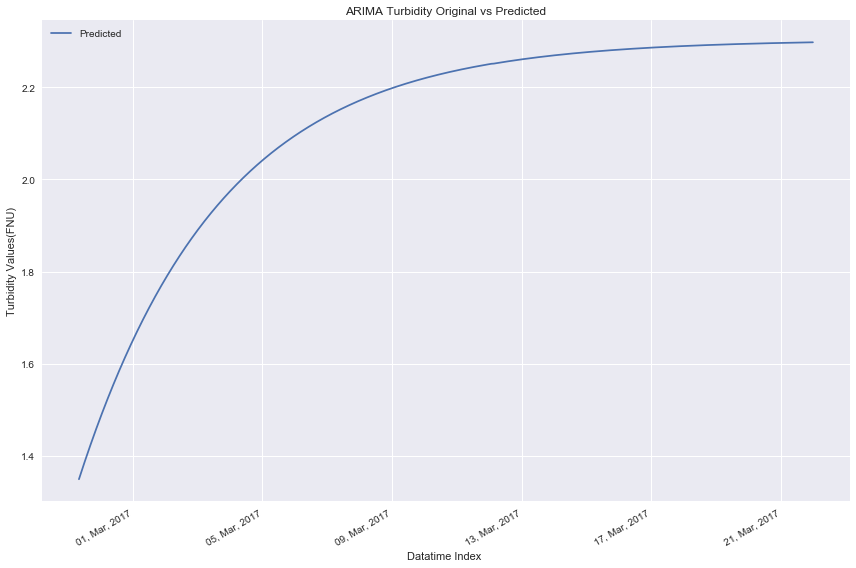

In [90]:
plt.style.use('seaborn')
plt.figure(figsize=(12,8))
plt.plot_date(date_test,forecast3, linestyle='solid', marker='',label='Predicted')
plt.gcf().autofmt_xdate()
date_format = mpl_dates.DateFormatter('%d, %b, %Y')
plt.gca().xaxis.set_major_formatter(date_format)
plt.xlabel("Datatime Index ")
plt.ylabel("Turbidity Values(FNU)")
plt.title('ARIMA Turbidity Original vs Predicted')
plt.legend(loc='best')
plt.tight_layout()

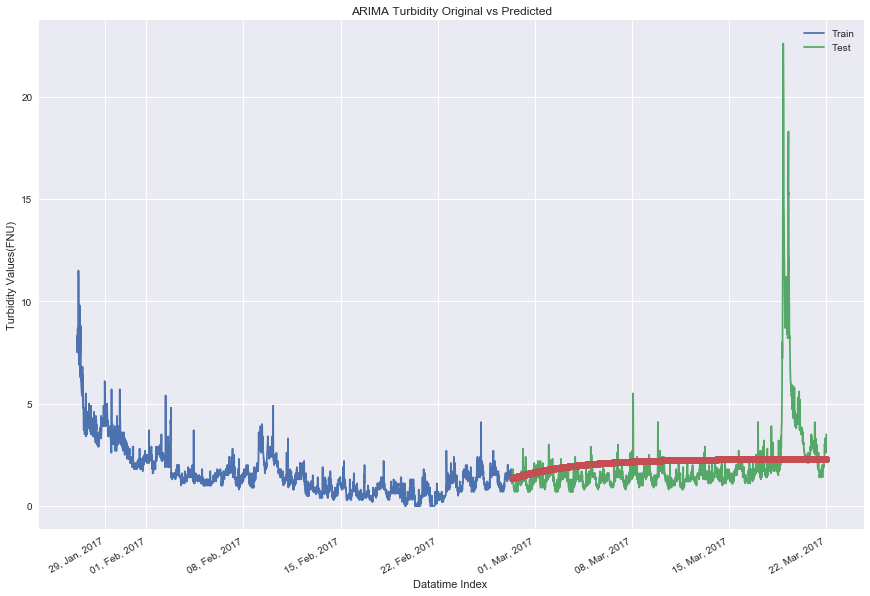

In [91]:
# plot predictions and actual values 

plt.style.use('seaborn')
plt.figure(figsize=(12,8))

plt.plot(turb_train, label='Train')
plt.plot(turb_test, label='Test')
plt.plot_date(date_test,forecast3, linestyle='solid')
#plt.plot(predictions, label='Predictions')

plt.gcf().autofmt_xdate()
date_format = mpl_dates.DateFormatter('%d, %b, %Y')
plt.gca().xaxis.set_major_formatter(date_format)
plt.tight_layout()
plt.xlabel("Datatime Index ")
plt.ylabel("Turbidity Values(FNU)")
plt.title('ARIMA Turbidity Original vs Predicted')
plt.legend(loc='best')
plt.show()
#predictions.plot(legend = True) 
#turb_test.plot(legend = True) 

## Error Analysis

#### Generating prerequisite arrays for error Calculation

In [107]:
predictions_values = forecast3.values

print(predictions_values.size)

turb_test_values = turb_test.values

print(turb_test_values.size)

expected = turb_test_values
predicted = predictions_values

2171
2171


#### Bias Calculation

In [108]:
forecast_errors = [expected[i]-predicted[i] for i in range(len(expected))]
bias = sum(forecast_errors) * 1.0/len(expected)
print('Bias: %f' % bias)

Bias: -0.216094


#### Mean Absolute Error

In [109]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(expected, predicted)
print('Mean Absolute Error: %f' % mae)

Mean Absolute Error: 0.965910


#### Mean Squared Error

In [110]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(expected, predicted)
print('MSE: %f' % mse)

MSE: 3.418048


#### Root Mean Squared Error

In [111]:
from math import sqrt
rmse_sarima = sqrt(mse)
print('RMSE: %f' % rmse_sarima)

RMSE: 1.848796


## Before beginning Anomaly Detection we again import the dataset for plotting the anomaly values

We will again import dataset, but not set index as the datetime column for plotting the outliers

In [5]:
def parser(x):
    return datetime.strptime(x,'%Y-%m-%d %H:%M')
data_iso = pd.read_csv('C:/users/admin/swq/Dataset/Data7.csv',header=0, delimiter=',', parse_dates=[0], date_parser=parser)

Dataset NaN values are filled with previous cell values

In [6]:
data_iso = data_iso.fillna(method ='pad') 
turb_iso = data_iso.filter(['date_time','Turb(FNU)'], axis=1)

t = turb_iso

t.shape

(5171, 2)

# Anomaly Detection of Dataset

### Isolation Forest Outlier Plot

In [25]:
#Isolation Forest Model Prediction
train_size2,test_size2 = 1920, 3251#in paper given as 3169
#train_size,test_size = 3000, 2171

turb_train2,turb_test2 = tts(turb,train_size = train_size2, random_state=0, shuffle=False)
train2, test2 = turb_train2.values, turb_test2.values

model= IsolationForest(n_estimators=100)
#model = IsolationForest(behaviour = 'new')
model.fit(turb_train2)
turb_pred = model.predict(turb_test2)
print("Valid cases Accuracy:", list(turb_pred).count(1)/turb_pred.shape[0])
Fraud_pred = model.predict(turb_test2)

Valid cases Accuracy: 0.7557674561673331


The above result tells us the accuracy of Isolation Forest on the data set

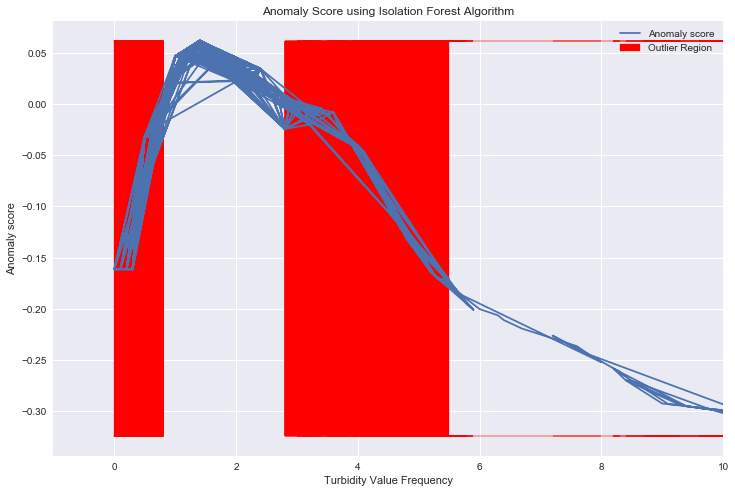

In [36]:

isolation_forest = IsolationForest(n_estimators=100)#Tree given to be 100
#isolation_forest.fit(train2.reshape(-1, 1))
isolation_forest.fit(train2)
#xx = np.linspace(-6, 6, 100).reshape(-1,1)
#xx = test2.reshape(-1,1)
xx = test2
anomaly_score = isolation_forest.decision_function(xx)
outlier = isolation_forest.predict(xx)
plt.figure(figsize=(12,8))
plt.plot(xx, anomaly_score, label='Anomaly score')
plt.fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score), where=outlier==-1, color='r', label='Outlier Region')
plt.legend()
plt.ylabel('Anomaly score')
plt.xlabel('Turbidity Value Frequency')
plt.title('Anomaly Score using Isolation Forest Algorithm')
plt.xlim([-1, 10])

plt.show()

In [31]:
date_test = date.iloc[1920:,0]

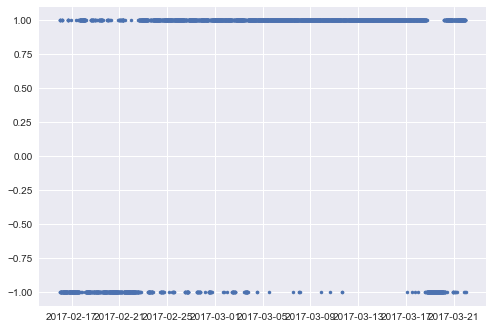

In [35]:
plt.plot(date_test,outlier,linestyle='',marker='.')

## Isolation Forest Outlier

We will now implement Isolation Forest Anomaly Detection Method

In [9]:
from sklearn.preprocessing import StandardScaler

#data = t['Turb(FNU)']
data = turb
scaler = StandardScaler()
np_scaled = scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)

# train isolation forest
outliers_fraction = 0.01
model =  IsolationForest(contamination='auto')
model.fit(data) 
#anomaly = pd.Series(model.predict(data))

IsolationForest(behaviour='deprecated', bootstrap=False, contamination='auto',
                max_features=1.0, max_samples='auto', n_estimators=100,
                n_jobs=None, random_state=None, verbose=0, warm_start=False)

anomaly_data is used to store the anomaly row values

In [10]:
t['anomaly']=pd.Series(model.predict(data))

anomaly_data = t.loc[t['anomaly'] == -1, ['date_time','Turb(FNU)']]

anomaly_data.shape

print("Percentage of anomalies in data: {:.2f}".format((len(t.loc[t['anomaly']==-1])/len(t))*100))

Percentage of anomalies in data: 20.44


In [11]:
anomaly_data.shape

(1057, 2)

In [12]:
t.head()

,date_time,Turb(FNU),anomaly
0,2017-01-27 00:00:00,8.3,-1
1,2017-01-27 00:15:00,8.3,-1
2,2017-01-27 00:30:00,7.8,-1
3,2017-01-27 00:45:00,8.0,-1
4,2017-01-27 01:00:00,7.5,-1


We will now plot the points which are supposed to be outliers than the normal points

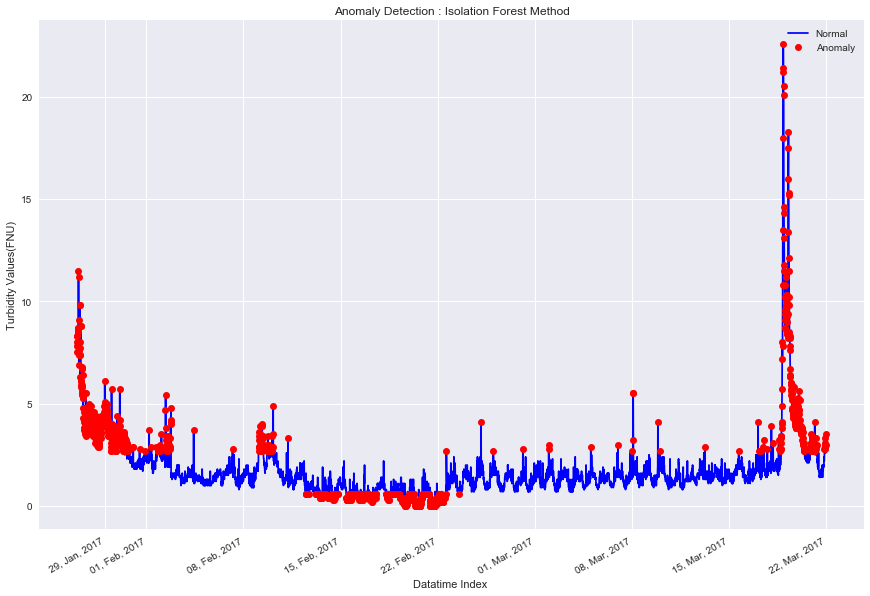

In [13]:
plt.style.use('seaborn')
plt.figure(figsize=(12,8))

plt.plot(t['date_time'],t['Turb(FNU)'], color='blue', label = 'Normal')
plt.plot_date(x=anomaly_data['date_time'],y=anomaly_data['Turb(FNU)'], color='red', label = 'Anomaly')

#plt.plot(predictions, label='Predictions')

plt.gcf().autofmt_xdate()
date_format = mpl_dates.DateFormatter('%d, %b, %Y')
plt.gca().xaxis.set_major_formatter(date_format)
plt.tight_layout()
plt.xlabel("Datatime Index ")
plt.ylabel("Turbidity Values(FNU)")
plt.title('Anomaly Detection : Isolation Forest Method')
plt.legend()
plt.show()


In [15]:
print("Accuracy:", list(t).count(-1)/y_pred_outliers.shape[0])

NameError: name 'y_pred_outliers' is not defined

## Anomaly Detection using OpenSVM

We will now implement OpenSVM Anomaly Detection Method

In [18]:
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler
outliers_fraction = 0.1
data2 = turb
scaler = StandardScaler()
np_scaled = scaler.fit_transform(data)
data2 = pd.DataFrame(np_scaled)
# train oneclassSVM 
model = OneClassSVM( kernel="rbf", gamma=0.01)
model.fit(data)

OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma=0.01, kernel='rbf',
            max_iter=-1, nu=0.5, shrinking=True, tol=0.001, verbose=False)

anomaly_data_SVM is used to store the anomaly row values

In [19]:
t['anomalySVM']=pd.Series(model.predict(data))

anomaly_data_SVM = t.loc[t['anomalySVM'] == -1, ['date_time','Turb(FNU)']]

anomaly_data_SVM.shape

(2874, 2)

We will now plot the points which are supposed to be outliers than the normal points

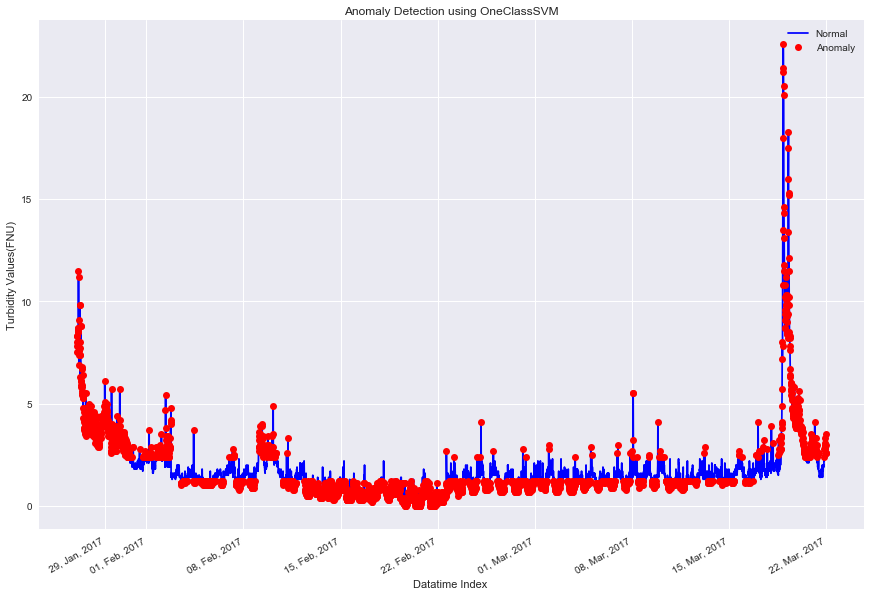

In [20]:
plt.style.use('seaborn')
plt.figure(figsize=(12,8))

plt.plot(t['date_time'],t['Turb(FNU)'], color='blue', label = 'Normal')
plt.plot_date(x=anomaly_data_SVM['date_time'],y=anomaly_data_SVM['Turb(FNU)'], color='red', label = 'Anomaly')

#plt.plot(predictions, label='Predictions')

plt.gcf().autofmt_xdate()
date_format = mpl_dates.DateFormatter('%d, %b, %Y')
plt.gca().xaxis.set_major_formatter(date_format)
plt.tight_layout()
plt.xlabel("Datatime Index ")
plt.ylabel("Turbidity Values(FNU)")
plt.title('Anomaly Detection using OneClassSVM')
plt.legend(loc='best')
plt.show()


## Anomaly Detection using Gaussian Distribution

We will now implement Gaussian Anomaly Detection Method

In [22]:
from sklearn.covariance import EllipticEnvelope
outlier_fraction = 0.1
data_g = turb
envelope =  EllipticEnvelope() 
X_train = data_g.values.reshape(-1,1)
envelope.fit(X_train)

EllipticEnvelope(assume_centered=False, contamination=0.1, random_state=None,
                 store_precision=True, support_fraction=None)

anomaly_data_gaussian is used to store the anomaly row values

In [23]:
data_g = pd.DataFrame(data_g)
#t['deviation'] = envelope.decision_function(X_train)
t['anomalyGaussian'] = envelope.predict(X_train)
anomaly_data_gaussian = t.loc[t['anomalyGaussian'] == -1, ['date_time','Turb(FNU)']] #anomaly

anomaly_data_gaussian.shape

(517, 2)

In [134]:
anomaly_data_gaussian.head()

,date_time,Turb(FNU)
0,2017-01-27 00:00:00,8.3
1,2017-01-27 00:15:00,8.3
2,2017-01-27 00:30:00,7.8
3,2017-01-27 00:45:00,8.0
4,2017-01-27 01:00:00,7.5


We will now plot the points which are supposed to be outliers than the normal points

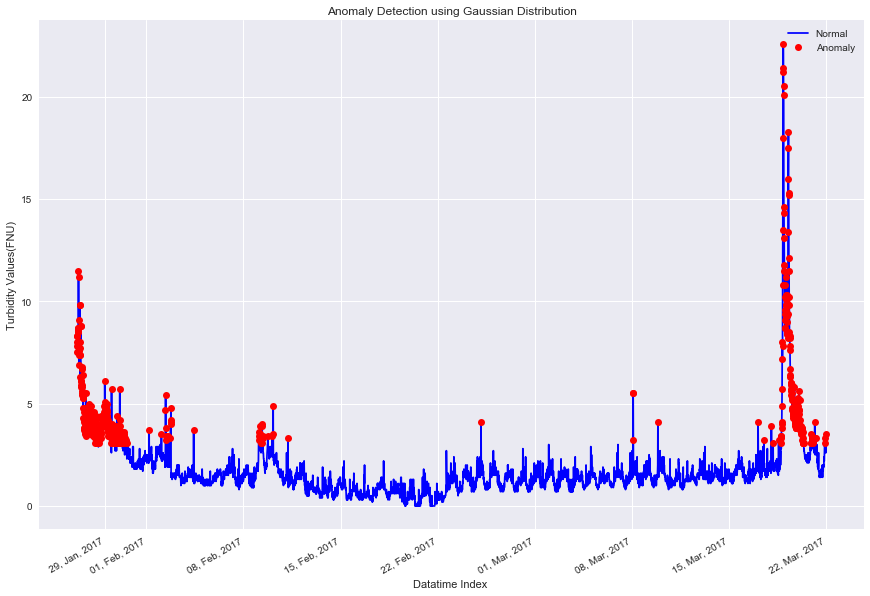

In [136]:
plt.style.use('seaborn')
plt.figure(figsize=(12,8))

plt.plot(t['date_time'],t['Turb(FNU)'], color='blue', label = 'Normal')
plt.plot_date(x=anomaly_data_gaussian['date_time'],y=anomaly_data_gaussian['Turb(FNU)'], color='red', label = 'Anomaly')

#plt.plot(predictions, label='Predictions')

plt.gcf().autofmt_xdate()
date_format = mpl_dates.DateFormatter('%d, %b, %Y')
plt.gca().xaxis.set_major_formatter(date_format)
plt.tight_layout()
plt.xlabel("Datatime Index ")
plt.ylabel("Turbidity Values(FNU)")
plt.title('Anomaly Detection using Gaussian Distribution')
plt.legend(loc='best')
plt.show()
